In [ ]:
# importing 

Importing the required and necessary libraries



In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib as mpl
import scipy.stats as si

In [ ]:
We source our selected S&P 500 stock (Amazon.com Inc.) data from yahoo finance, covering the period Oct 2020 to June 2021.   

In [64]:
tick='AMZN' 
start="2020-10-01"
end="2021-06-15"
df = yf.download(tick,start,end)

[*********************100%***********************]  1 of 1 completed


In [65]:
df.tail() #view last 4 row of data (data frame)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-06-08,3222.610107,3279.530029,3218.010010,3264.110107,3264.110107,3416700
2021-06-09,3272.870117,3297.580078,3270.699951,3281.149902,3281.149902,2455500
2021-06-10,3282.010010,3351.000000,3281.149902,3349.649902,3349.649902,3476500
2021-06-11,3349.649902,3366.580078,3333.449951,3346.830078,3346.830078,2813900
2021-06-14,3346.830078,3385.000000,3335.500000,3383.870117,3383.870117,2569700


Data description and graghical visualization 

In [66]:
df=df['Adj Close'] #df now become a data series
df.describe().round(2) #describe data

count     177.00
mean     3213.47
std       107.50
min      2951.95
25%      3135.66
50%      3206.22
75%      3286.65
max      3471.31
Name: Adj Close, dtype: float64

In [67]:
Price = df[-1] #last entry of data - last price
print('The spot price is', round(Price,2))

The spot price is 3383.87


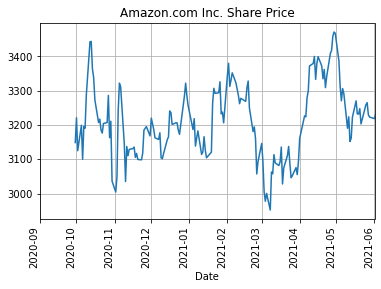

In [68]:
df.plot(label=tick)
plt.xlabel('Date')
plt.title('Amazon.com Inc. Share Price') 
plt.xticks(rotation=90)
plt.xlim('2020-09','2021-06')
plt.grid()

Calculation of the return and moving averages and add to new data frame

In [69]:
ret=np.log(df/df.shift(1)) #calculate log return
data=pd.concat([df,ret], axis=1) #combine two series and crate a data frame 
data.columns=['Price', 'Return'] #rename columns
data.dropna(inplace=True) #drop na values
data.tail()

,Price,Return
Date,,
2021-06-08,3264.110107,0.020458
2021-06-09,3281.149902,0.005207
2021-06-10,3349.649902,0.020662
2021-06-11,3346.830078,-0.000842
2021-06-14,3383.870117,0.011006


In [74]:
w=5                                  
# 5 days moving averages as Amazon.com share is volatile 
data['min'] = data['Price'].rolling(w).min()
data['max'] = data['Price'].rolling(w).max()
data['std'] = data['Price'].rolling(w).std()
data['mean'] = data['Price'].rolling(w).mean()
data['median'] = data['Price'].rolling(w).median()
data['ewma'] = data['Price'].ewm(halflife=0.5, min_periods=14).mean()
data.dropna().head()

,Price,Return,min,max,std,mean,median,ewma
Date,,,,,,,,
2020-10-20,3217.010010,0.003051,3207.209961,3363.709961,70.296410,3279.857959,3272.709961,3219.848770
2020-10-21,3184.939941,-0.010019,3184.939941,3338.649902,61.953347,3244.103955,3217.010010,3193.667149
2020-10-22,3176.399902,-0.002685,3176.399902,3272.709961,37.857493,3211.653955,3207.209961,3180.716714
2020-10-23,3204.399902,0.008776,3176.399902,3217.010010,16.765229,3197.991943,3204.399902,3198.479105
2020-10-26,3207.040039,0.000824,3176.399902,3217.010010,16.742028,3197.957959,3204.399902,3204.899806


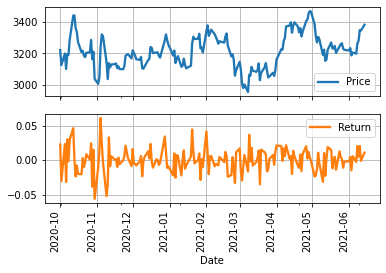

In [75]:
data[['Price','Return']].plot(subplots=True, lw=2.3, grid=True)
plt.xticks(rotation=90)
plt.show()

Visualizing the cummulative return

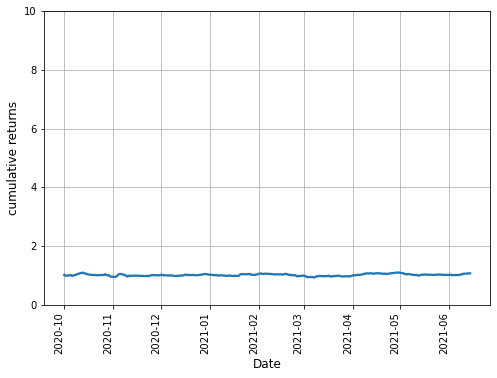

In [76]:
data['Return'].cumsum().apply(np.exp).plot(figsize=(8, 6), lw=2.3)
plt.grid(True)
plt.xticks(rotation=90)
plt.xlabel('Date',fontsize=12)
#plt.title('Tesla Inc. Shares Cumulative Returns', fontsize=20)
plt.ylabel('cumulative returns',fontsize=12)
plt.ylim(0,10)
plt.show()


Plotting the Distribution of Stock Return

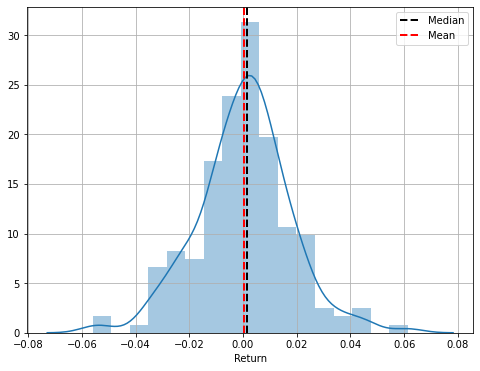

In [77]:
plt.figure(figsize=(8,6))
ax=sns.distplot(data['Return'])
ax.axvline(data['Return'].median(), color='black', ls='--', label='Median',lw=2)
ax.axvline(data['Return'].mean(), color='red', ls='--', label='Mean',lw=2)
plt.legend(loc=0)
plt.grid(True)


In [78]:
data['Return'].describe()

count    176.000000
mean       0.000409
std        0.017513
min       -0.055995
25%       -0.009297
50%        0.001441
75%        0.010923
max        0.061311
Name: Return, dtype: float64

price comparism:
The 5 and 20 days moving averages is utilized in the price comparism.

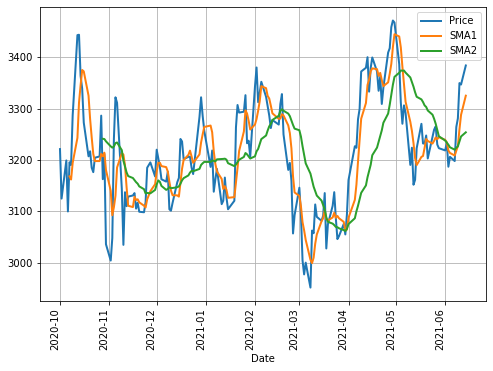

In [79]:
SMA1=5
SMA2=20
data['SMA1'] = data['Price'].rolling(window=SMA1).mean()
data['SMA2'] = data['Price'].rolling(window=SMA2).mean()
data[['Price', 'SMA1', 'SMA2']].plot(figsize=(8,6), grid=True, lw=2)
#plt.title('Moving Averages and Price')
plt.xticks(rotation=90)
plt.show()

# Option Pricing
Monte Carlo simulation is a widely used model to simulate the price of an underlying assets. Here we use 3000 simulation to simulate prices. Then we use payoff function max(K-S,0) to value put option

In [87]:
def mcs_simulation_np(p):
    M = p
    I = p
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * rn[t]) 
    return S

In [88]:
T = 1/12                                              # one month maturity or time to expiration
r = 0.96/100                                          # US risk free rate as of December 08,2020
sigma = data['Return'].std()*np.sqrt(len(data))       #annual volatility 
S0 = data['Price'][-1]                                #last price of the stock
K = 650                                               #strike price
q=0                                                   #tesla do not pay divident

In [89]:
S = mcs_simulation_np(3000) # 3000 simulations for the stock price
S = np.transpose(S)
S

array([[3383.87011719, 3386.64672763, 3393.99991348, ..., 3290.97013768,
        3294.53489538, 3298.56490334],
       [3383.87011719, 3387.3451515 , 3387.87116425, ..., 3352.54838736,
        3357.04500638, 3358.51204093],
       [3383.87011719, 3384.36035008, 3388.77039709, ..., 3335.19846721,
        3329.79613441, 3336.37685502],
       ...,
       [3383.87011719, 3386.92302876, 3388.5631049 , ..., 3260.53508984,
        3265.1354552 , 3262.16758342],
       [3383.87011719, 3382.81427879, 3379.51944818, ..., 3139.99050929,
        3141.40404265, 3144.70571424],
       [3383.87011719, 3387.48160456, 3381.81731274, ..., 3039.80107251,
        3035.29629188, 3037.88311716]])

Text(0, 0.5, 'Frequency')

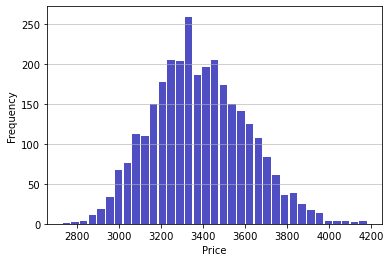

In [90]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(x=S[:,-1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Price')
plt.ylabel('Frequency')
#plt.title('Frequency distribution of the simulated end-of-preiod values')

In [91]:
print('Mean of Simulated Prices is {} and standard deviation is "{}!"'.format(S.mean().round(2), S.std().round(2)))

Mean of Simulated Prices is 3381.03 and standard deviation is "159.52!"


In [92]:
p = np.mean(np.maximum(K - S[:,-1],0))
print('European put', str(p))

European put 0.0


# Black Scholes Merton Model

Black Scholes Merton model uses last price,strike, time to expiry, risk free rate, divident yield and annual volatility to price option. We use same values that we used for MCS to price put option unde BSM.

In [93]:
def euro_put_bsm(S, K, T, r, q, vol):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: risk free rate
    #q: continuous dividend yield
    #vol: volatility of underlying asset
 
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    #if payoff == "call":
        
    #option_value = S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    #elif payoff == "put":
    option_value =  - S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0,1.0)
    
    return option_value

In [94]:
euro_put_bsm(S0,K,T,r,q,sigma)

1.9447148914120334e-133

In [95]:
TX = np.linspace(0.25,3,12) #create 12 values between 0.25 and 3
cpd = np.zeros((len(TX),1))
for i in range(len(TX)):
    cpd [i] = euro_put_bsm(S0, K, TX[i], r, q, sigma) # for each maturity crate an option value

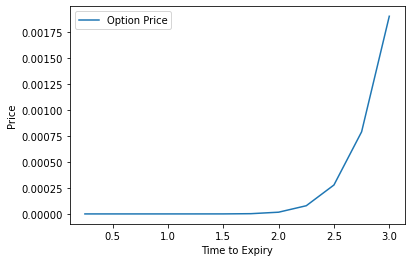

In [96]:
fig = plt.figure()
plt.plot(TX, cpd, '-')
plt.xlabel('Time to Expiry')
plt.ylabel('Price')
#plt.title('European Put')
plt.legend(['Option Price'])

In [97]:
SI = np.linspace(300,900,11)               #start 300 and stop 900 with 11 points, tesla very volatile 
cp = np.zeros((len(SI),1))
for i in range(len(SI)):
    cp[i] = euro_put_bsm(SI[i], K, T, r, q, sigma)

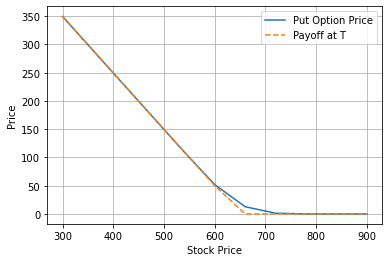

In [98]:
fig = plt.figure()
plt.plot(SI, cp, '-')                    #stock price and option prce
plt.plot(SI, np.maximum(K-SI,0), '--')   # stock price and payoff 
plt.xlabel('Stock Price')
plt.ylabel('Price')
#plt.title('European Put')
plt.legend(['Put Option Price','Payoff at T'])
plt.grid()


# Greeks
# Delta
The measure of option price sensitivity to stock price, first derivative of the option price with respect to stock price

In [99]:
def delta(S, K, T, r, q, vol):#use same parameters with BSM
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    delta =  - np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0)
    
    return delta

In [100]:
delta(S0, K, T, r, q, sigma)

-2.1129432529662977e-134

In [101]:
SD = np.linspace(S0-400,S0+500,51) #create an array for x axis
Delta_Put = np.zeros((len(SD),1))  #initiate delta as len(SD)x1 array 
for i in range(len(SD)):
    Delta_Put [i] = delta(SD[i], K, T, r, q, sigma)

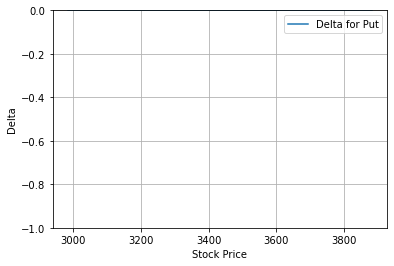

In [102]:
fig = plt.figure()
plt.plot(SD, Delta_Put, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Delta')
#plt.title('Delta')
plt.ylim(-1,0)
plt.legend(['Delta for Put'])
plt.show()

In [103]:
SD1=np.linspace(S0-200,S0+200,51) #Instead of S, SD is taken to avoid variable changes 
TD=np.linspace(0.5,2,31)        #instead of T, we used TD because we use T for inital valuues above 
Delta = np.zeros((len(TD),len(SD1)))
for j in range(len(SD1)):
    for i in range(len(TD)):
        Delta[i,j] = delta(SD1[j], K, TD[i], r, q, r)

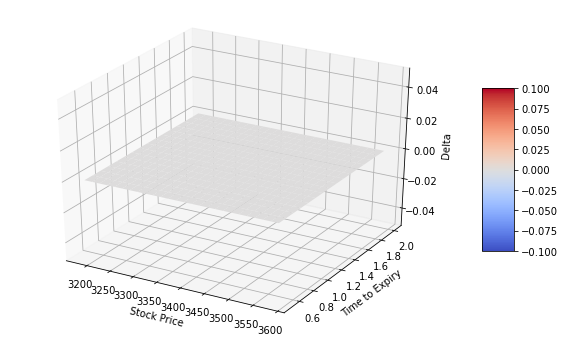

In [104]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d') #Get the current Axes instance on the current figure matching the given keyword args.
SD1, TD = np.meshgrid(SD1, TD) # extend dimention of the matrix (2D to 3D)
surf = ax.plot_surface(SD1, TD, Delta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Delta')
fig.colorbar(surf, shrink=0.5, aspect=5);

# Gamma¶
estimate delta sensitivity to price change of underlying

In [105]:
def gamma(S, K, T, r, q, vol):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    gamma = np.exp(-r * T) * si.norm.pdf(d1, 0.0, 1.0) / (vol * S * T)
    
    return gamma

In [106]:
gamma(S0, K, T, r, q, sigma)

7.954849327925686e-135

In [107]:
SG = np.linspace(S0-300,S0+300,21)
Gamma = np.zeros((len(SG),1))
for i in range(len(SG)):
    Gamma [i] = gamma(SG[i], K, T, r, q, sigma)

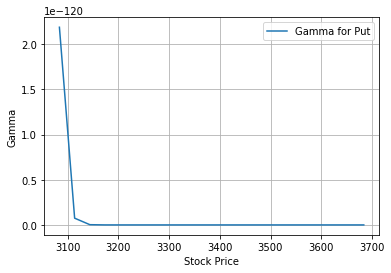

In [108]:
fig = plt.figure()
plt.plot(SG, Gamma, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Gamma')
#plt.title('Gamma')
plt.legend(['Gamma for Put'])

# Speed
measures gamma sensitivity to price change. It is third derivative of option price wrt stock price

In [109]:
def speed(S, K, T, r, q, vol):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    speed = np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / ((vol **2) * (S**2) * T) * (d1 + vol * np.sqrt(T))
    
    return speed

In [110]:
speed(S0,K,T,r,q,sigma)

2.502406483384548e-136

In [111]:
SP = np.linspace(S0-300,S0+300,21)
Speed = np.zeros((len(SP),1))
for i in range(len(SP)):
    Speed [i] = speed(SP[i], K, T, r, q, sigma)

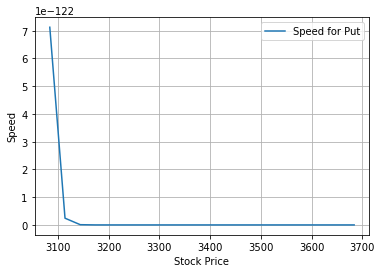

In [112]:
fig = plt.figure()
plt.plot(SP, Speed, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Speed')
#plt.title('Speed')
plt.legend(['Speed for Put'])

# Vega
estimate option price sensitivity to percent change in impled volatility

In [113]:
def vega(S, K, T, r, q, vol):
    # theata of put option
    #S: stock price
    #K: strike price 
    # r: annual risk free rate
    #q: divident yield
    #vol: annual volatility 
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    vega = S * np.sqrt(T) * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0)
    
    return vega

In [114]:
vega(S0, K, T, r, q, sigma)

5.094965765166055e-130

In [115]:
vol = np.linspace(0.1,0.8,21)
Vega = np.zeros((len(vol),1))
for i in range(len(vol)):
    Vega [i] = vega(S0, K, T, r, q, vol[i])

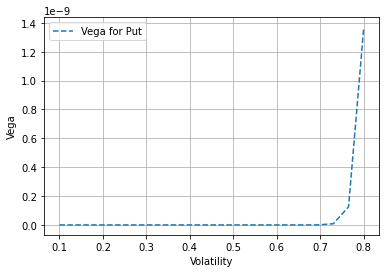

In [116]:
fig = plt.figure()
plt.plot(vol, Vega, '--')
plt.grid()
plt.xlabel('Volatility')
plt.ylabel('Vega')
#plt.title('Vega')
plt.legend(['Vega for Put'])

In [117]:
SV = np.linspace(S0-300,S0+300,51)
TV = np.linspace(0.5, 2, 51)
Vega = np.zeros((len(TV),len(SV)))
for j in range(len(SV)):
    for i in range(len(TV)):
        Vega[i,j] = vega(SV[j], K, TV[i], r, q, sigma)

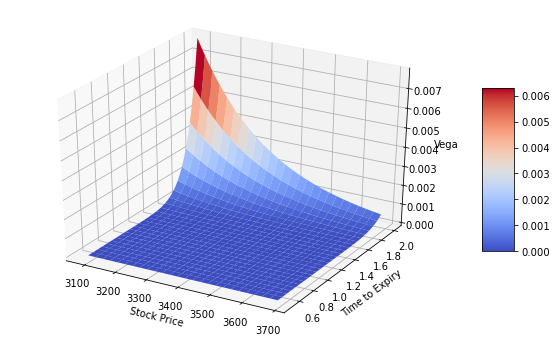

In [118]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d') #3d plot 
SV, TV = np.meshgrid(SV, TV) 
surf = ax.plot_surface(SV, TV, Vega, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Vega')
fig.colorbar(surf, shrink=0.5, aspect=5);

# Theta

In [119]:
def theta(S, K, T, r, q, vol):
    # theata of put option
    #S: stock price
    #K: strike price 
    # r: annual risk free rate
    #q: divident yield
    #vol: annual volatility 
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    
    theta = vol * S * np.exp(-q * T) * si.norm.pdf(-d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return theta

In [120]:
theta(S0, K, T, r, q, sigma )

7.1091806814715015e-130

In [121]:
TH= np.linspace(0.25,3,12)

Theta = np.zeros((len(TH),1))
for i in range(len(TH)):
    Theta[i] = theta(S0, K, TH[i], r, q, sigma)

Text(0, 0.5, 'Theta')

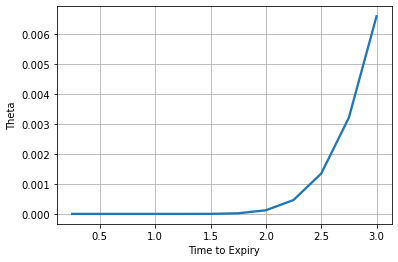

In [122]:
fig = plt.figure()
plt.plot(TH, Theta, '-', lw=2.3)
plt.grid()
plt.xlabel('Time to Expiry')
plt.ylabel('Theta')
#plt.title('Theta')
#plt.legend( 'Theta for Put')

In [123]:
SHX = np.linspace(S0-300,S0+300,51)
THX = np.linspace(0.5, 2, 51)
Theta = np.zeros((len(THX),len(SHX)))
for j in range(len(SHX)):
    for i in range(len(THX)):
        Theta[i,j] = theta(SHX[j], K, THX[i], r, q, sigma)

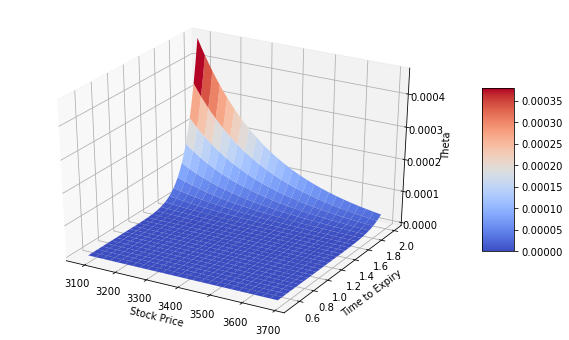

In [124]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
SHX, THX = np.meshgrid(SHX, THX)
surf = ax.plot_surface(SHX, THX, Theta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Theta')
fig.colorbar(surf, shrink=0.5, aspect=5);